# Neural Networks

## 1. Neural Networks
In this section, we will implement backpropagation algorithm to learn the parameters for the neural network.

### 1.1 Visualizing the data
The data is the same as assignment 3, 5000 training examples, each contains a 20 pixel by 20 pixel grayscale image of the digit. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
from scipy.io import loadmat

data = loadmat('ex3data1.mat')

X = data["X"]   # 5000x400 np array
y = data["y"]   # 5000x1 np array (2d)
y = y.flatten() # change to (5000,) 1d array and 
y[y==10] = 0    # convert to 0-9 scale from 1-10 scale

In [3]:
def displayData(X):
    """displays the 100 rows of digit image data stored in X in a nice grid. 
        It returns the figure handle fig, ax
    """
    
    # form the big 10 x 10 matrix containing all 100 images data
    # padding between 2 images
    pad = 1
    # initialize matrix with -1 (black)
    wholeimage = -np.ones((20*10+9, 20*10+9))
    # fill values
    for i in range(10):
        for j in range(10):
            wholeimage[j*21:j*21+20, i*21:i*21+20] = X[10*i+j, :].reshape((20, 20))
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(wholeimage.T, cmap=plt.cm.gray, vmin=-1, vmax=1)
    ax.axis('off')
    
    return fig, ax

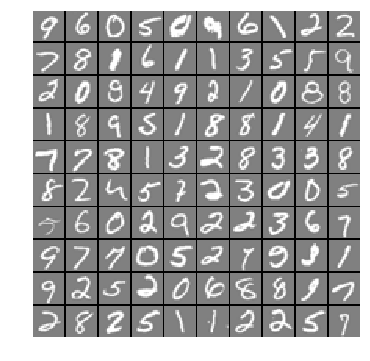

In [4]:
# randomly select 100 data points to display
rand_indices = np.random.randint(0, 5000, size=100)
sel = X[rand_indices, :]

# display images
fig, ax = displayData(sel)

### 1.2 Model representation
Our neural network is shown in the following figure. It has 3 layers: an input layer, a hidden layer and an output layer. The neural network used contains 25 units in the 2nd layer and 10 output units (corresponding to 10 digit classes).

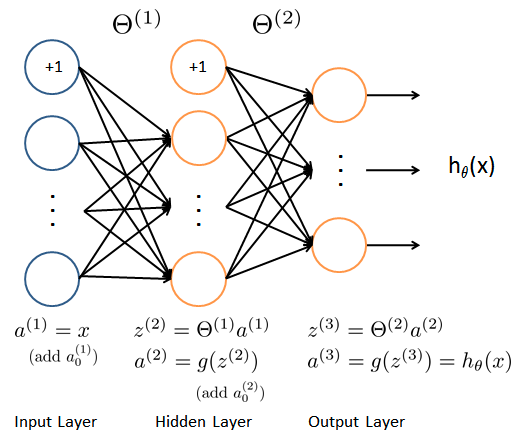



### 1.3 Feedforward and cost function
Recall that the cost function for the neural network (without regularization) is:
$$ J(\theta)=\frac{1}{m}\sum_{i=1}^{m} \sum_{k=1}^{K}[-y^{(i)}log((h_\theta(x^{(i)}))_k)-(1-y^{(i)})log(1-(h_\theta(x^{(i)}))_k)]$$

where $h_\theta(x^{(i)})$ is computed as shown in the above figure and K=10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation of the k-th output unit. Also, remember that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, so:


$$ y = \left[\matrix{1\\ 0\\ 0\\ \vdots\\ 0}\right], \left[\matrix{0\\ 1\\ 0\\ \vdots\\ 0}\right], ..., or \left[\matrix{0\\ 0\\ 0\\ \vdots\\ 1}\right] $$

#### Vectorization
Matrix dimensions:

$X_{wb}$: 5000 x 401

$\Theta^{(1)}$: 25 x 401

$\Theta^{(2)}$: 10 x 26

$a^{(2)}$: 5000 x 25 or 5000 x 26 after adding intercept terms

$a^{(3)} or H_\theta(x)$: 5000 x 10

$Y$: 5000 x 10

$$a^{(2)} = g(X_{wb}\Theta^{(1)^T})$$

$$ H_\theta(x) = a^{(3)} = g(a^{(2)}_{wb}\Theta^{(2)^T})$$

$$ H_\theta(x) = \left[\matrix{-(h_\theta(x^{(1)}))^T-\\ -(h_\theta(x^{(2)}))^T-\\ \vdots\\ -(h_\theta(x^{(m)}))^T-}\right] $$

$$ Y = \left[\matrix{-(y^{(1)})^T-\\ -(y^{(2)})^T-\\ \vdots\\ -(y^{(m)})^T-}\right] $$

Therefore, cost is:

$$ J(\theta)=\frac{1}{m} \sum_{matrix-elements} (-Y .* log(H_\theta(x))-(1-Y) .* log(1-H_\theta(x))) $$

Note the element wise multiplication (.*) and sum of all matrix elements in the above equation.

### 1.4 Regularized cost function
The cost function for neural networks with regularization is given by:
$$ J(\theta)=\frac{1}{m}\sum_{i=1}^{m} \sum_{k=1}^{K}[-y^{(i)}log((h_\theta(x^{(i)}))_k)-(1-y^{(i)})log(1-(h_\theta(x^{(i)}))_k)] + \frac{\lambda}{2m}\left[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j, k}^{(1)})^2 + \sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j, k}^{(2)})^2\right]$$

Note that even though the additional regularization term seems complicated with all the cascaded Sigma symbols, it is actually just the sum of all elements (after taking square) in the $\Theta$ matrix, one of them is 25 by 400, the other is 10 by 25 (recall that bias term is by convention not included in regularization). If your regularization parameter $\lambda$ is very very large, then all your $\Theta$ will converge to zero.

#### Vectorization
For the regularization term, there's actually nothing much to vectorize. Using elementwise self-multiplication then sum all elements in the result will do it: 

$$ J(\theta)=\frac{1}{m} \sum_{matrix-elements} (-Y .* log(H_\theta(x))-(1-Y) .* log(1-H_\theta(x))) + \frac{\lambda}{2m} \left[\sum_{matrix-elements}(\Theta_{j, k}^{(1)} .* \Theta_{j, k}^{(1)})+\sum_{matrix-elements}(\Theta_{j, k}^{(2)} .* \Theta_{j, k}^{(2)})\right]$$

In [18]:
def sigmoid(z):
    """sigmoid(z) computes the sigmoid of z. z can be a number,
    vector, or matrix. 
    """
    
    g = 1 / (1 + np.exp(-z))
    
    return g

In [23]:
def nnCostFunction(nn_params, input_lsize, hidden_lsize, num_labels, X, y, lmd):
    """computes the cost and gradient of the neural network. The
%   parameters for the neural network are "unrolled" into the vector
%   nn_params and need to be converted back into the weight matrices. 
% 
%   The returned parameter grad should be a "unrolled" vector of the
%   partial derivatives of the neural network.

    X should already include bias terms
    Y is a 2d matrix
    """
    
    # number of training samples
    m, n = X.shape
    
    # restore Theta1 and Theta2 from nn_params
    Theta1 = nn_params[:hidden_lsize*(input_lsize+1)].reshape((hidden_lsize, input_lsize+1))
    Theta2 = nn_params[hidden_lsize*(input_lsize+1):].reshape((num_labels, hidden_lsize+1))
    
    # forward propagation
    a2 = sigmoid(X @ Theta1.T)
    a2_wb = np.concatenate((np.ones((m, 1)), a2), axis=1)
    a3 = sigmoid(a2_wb @ Theta2.T) # i.e. H_theta
    
    # Calculate cost
    temp1 = -y * np.log(a3) - (1-y) * np.log(1-a3)
    temp2 = np.sum((Theta1**2).flatten()) + np.sum((Theta2**2).flatten())
    J = np.sum(temp1.flatten()) / m + lmd * temp2 / (2*m)
    
    return J
    

In [25]:
# define input_lsize, hidden_lsize and numb_labels
input_lsize = 400
hidden_lsize = 25
num_labels = 10
m = len(y) # number of samples

# add bias terms to X
X_wb = np.concatenate((np.ones((m, 1)), X), axis=1)

# convert y to 2d matrix Y, 5000 by 10
# each row represents a sample, containing 0 or 1
Y = np.zeros((m, num_labels))
for i, v in enumerate(y):
    Y[i, v] = 1
#print(Y[:100, :])

# Load pre-calculated nn_params Theta1 and Theta2
# In ex4weights are 2 parameters:
# Theta1: 25 by 401
# Theta2: 10 by 26

# from scipy.io import loadmat
data = loadmat('ex3weights.mat')

Theta1 = data["Theta1"]   
Theta2 = data["Theta2"]

# unroll Theta1 and Theta2 into nn_params
nn_params = np.concatenate((Theta1.flatten(), Theta2.flatten()))
print(nn_params.shape)   # should be (10285,)

# Regularization factor
lmd = 0

# Test nnCostFunction()
J = nnCostFunction(nn_params, input_lsize, hidden_lsize, num_labels, X_wb, Y, lmd)

print(J)
print("Expected ~0.287629")

(10285,)
10.4414596728
Expected ~0.287629


In [11]:
X.shape

(5000, 400)